# Handin Notebook for AcroMonk Trajectory Optimization

In [1]:
# # Do general python imports
import numpy as np
from matplotlib import pyplot as plt

# import utils
# Drake Imports
from pydrake.all import (MultibodyPlant, SceneGraph, Parser, DiagramBuilder, TrajectorySource, 
                         MultibodyPositionToGeometryPose, DirectCollocation, PiecewisePolynomial,
                         Solve, Simulator, LogVectorOutput, StartMeshcat, MeshcatVisualizer, 
                         RobotDiagramBuilder, AddMultibodyPlantSceneGraph)

from underactuated import ConfigureParser, running_as_notebook
from IPython.display import HTML, SVG, Markdown, display
import pydot

# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

l1 = 0.314
l2 = l1

def forward_kinematics(theta1, theta2):
    '''
    Function to compute the forward kinematics of the AcroMonk Robot,
    i.e. compute the end-effector position given the joint angles.
    Returns ons the (y,z) coordinates as the AcroMonk can only move in a plane.
    '''
    ee_y = (l1 * np.sin(theta1)) + (l2 * np.sin(theta1 + theta2))
    ee_z =   (-l1 * np.cos(theta1) - (l2 * np.cos(theta1 + theta2)))

    return ee_y, ee_z

def forward_diff_kinematics(theta1, theta2, theta1_dot, theta2_dot):
    '''
    Function to compute the differential forward kinematics of the AcroMonk Robot,
    i.e. compute the end-effector velocity given the join position/velocities
    Returns ons the (y_dot,z_dot) coordinates as the AcroMonk can only move in a plane.
    '''
    ee_y_dot = (l1 * theta1_dot * np.cos(theta1)) + (l2 * (theta1_dot + theta2_dot) * np.cos(theta1 + theta2))
    ee_z_dot = (l1 * theta1_dot * np.sin(theta1)) -(l2 * (theta1_dot + theta2_dot) * np.sin(theta1 + theta2))
    return ee_y_dot, ee_z_dot

def inverse_kinematics(ee_y, ee_z):
    # Compute inverse kinematics for the AcroMonk Robot 
    # Taken from the slides of lecture 04 page 40
    alpha = np.arccos((ee_y**2 + ee_z**2 + l1**2 - l2**2)/(2 * l1 * np.sqrt(ee_y**2 + ee_z**2)))
    beta = np.arccos((2*l1**2 - ee_y**2 - ee_z**2)/(2 * l1**2))
    gamma = np.arctan2(ee_z, ee_y)
    theta1 = gamma - alpha + np.pi/2
    theta2 = np.pi - beta
    return theta1, theta2


# Compute the distance between the end-effector and the first rung (where stance arm is resting)
def distance_to_first_rung(ee_y, ee_z):
    position = forward_kinematics(ee_y, ee_z)
    return np.sqrt(position[0]**2 + position[1]**2)

# Compute the distance between the end-effector and the second rung (you want to grab that)
def get_distance_between_endeffector_and_second_rung(theta1, theta2,rung):
    position = forward_kinematics(theta1, theta2)
    return (np.sqrt((position[0] - rung[0])**2 + (position[1] - rung[1])**2))

INFO:drake:Meshcat listening for connections at http://localhost:7003


# Task 1.

In [2]:
robot_urdf = "AcroMonkModel.urdf" # with horizontal ladder
# robot_urdf = "AcroMonkModel_VerticalLadder.urdf" # with vertical ladder

builder = RobotDiagramBuilder(time_step=0.0)
ConfigureParser(builder.parser())
builder.parser().AddModels(robot_urdf)
diagram = builder.Build()
context = diagram.CreateDefaultContext()




null_rung = (-0.34, 0) 
first_rung = (0,0) #in y and z coordinates
second_rung = (0.34, 0) #in y and z coordinates
#Initial State as specified in the exercise
initial_state = (0.0, 0.0, 0.0, 0.0)

# Add the Final State here.
y_deviation = 0.0
z_deviation = -0.016215

ee_y, ee_z = (0.34 + y_deviation), (0 + z_deviation) 
theta1, theta2 = inverse_kinematics(ee_y, ee_z)
print("Final state position: ", theta1, theta2)
# final_theta1_dot, final_theta2_dot = 0.0, -1.2
final_theta1_dot, final_theta2_dot = 0, 0
final_state = (-theta1, -theta2, final_theta1_dot, final_theta2_dot)
print("final state: ", final_state)
# Add the torque limit here
torque_limit = 2.5
# Add a velocity limit here, if needed
velocity_limit = 20.

Final state position:  0.5251798748635597 1.9959227664740098
final state:  (np.float64(-0.5251798748635597), np.float64(-1.9959227664740098), 0, 0)


## Setup the Trajectory Optimization Problem using `DirectCollocation`

Here, we use the `DirectCollocation` class to setup our trajectory optimization problem

In [3]:
acromonk_dircol = DirectCollocation(diagram,
                                    context,
                                    num_time_samples=30,
                                    minimum_time_step=0.01,
                                    maximum_time_step=0.5,
                                    input_port_index=diagram.GetInputPort("plant_actuation").get_index())

# Add Equal time interval constraint so that DirectCollocation doesn't stretch/shrink time
# in our trajectory.
_ = acromonk_dircol.AddEqualTimeIntervalsConstraints()

## Add Constraints

Add the constraints to the trajectory optimization problem here...

In [4]:
torque_init = acromonk_dircol.input(0)
_ = acromonk_dircol.AddConstraintToAllKnotPoints(torque_init[0] == 0)

# Add Torque Constraint 
u = acromonk_dircol.input()
acromonk_dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0]) #Min Torque Constraint
acromonk_dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)  #Max Torque Constraint

# Initial State Constraints
prog = acromonk_dircol.prog()
prog.AddBoundingBoxConstraint(initial_state, initial_state, acromonk_dircol.initial_state())

# Final State Constraints
prog.AddBoundingBoxConstraint(final_state, final_state, acromonk_dircol.final_state())

# Velocity Constraints
q_vector = acromonk_dircol.state()
acromonk_dircol.AddConstraintToAllKnotPoints(-velocity_limit <= q_vector[3])
acromonk_dircol.AddConstraintToAllKnotPoints(q_vector[3] <= velocity_limit)
acromonk_dircol.AddConstraintToAllKnotPoints(-velocity_limit <= q_vector[2])
acromonk_dircol.AddConstraintToAllKnotPoints(q_vector[2] <= velocity_limit)

# Collision Constraints
max_theta2 = (5*np.pi)/6 #is randomly chosen and has to be smaller than pi, cloud be calculated from known geometry
acromonk_dircol.AddConstraintToAllKnotPoints(-max_theta2 <= q_vector[1])
acromonk_dircol.AddConstraintToAllKnotPoints(q_vector[1] <= max_theta2)

barrier_radius = 0.015
acromonk_dircol.AddConstraintToAllKnotPoints(
    barrier_radius <= get_distance_between_endeffector_and_second_rung(q_vector[0], q_vector[1],second_rung)
)
acromonk_dircol.AddConstraintToAllKnotPoints(
    barrier_radius <= get_distance_between_endeffector_and_second_rung(q_vector[0], q_vector[1],first_rung)
)
acromonk_dircol.AddConstraintToAllKnotPoints(
    barrier_radius <= get_distance_between_endeffector_and_second_rung(q_vector[0], q_vector[1],null_rung)
)

## Adding Costs...

Add the costs to the trajectory optimizataion problem here...

To add a running cost you can use `acromonk_dircol.AddRunningCost(<cost here>)`

To add a terminal/final cost you can use `acromonk_dircol.AddFinalCost(<cost here>)`


**Remember!** The cost must be a positive scalar even though the quantities can be negative!

In [5]:
# Add a cost on the amount of torque/energy used
#torque_cost_weight = 20
torque_cost_weight = 10
acromonk_dircol.AddRunningCost(torque_cost_weight * u[0] ** 2)


# Add cost of velocity
other_cost_weight = 1
velocity_cost_weight = 3
acromonk_dircol.AddRunningCost(velocity_cost_weight * q_vector[3] ** 2)
acromonk_dircol.AddRunningCost(velocity_cost_weight * q_vector[2] ** 2)

#Add cost of time needed to complete the task
time_weight = 300
acromonk_dircol.AddFinalCost(acromonk_dircol.time() * time_weight)  

## Initial Guess for the Trajectory Optimization

We use an linear interpolation between the initial and the final state for the initial guess. This of course is not consistent with the dynamics of the system. Luckily, the mordern solvers (such as SNOPT as used here) are very flexible and allow for infeasible initial guesses which still lead to feasible, and sometimes even optimal, solutions.

In [6]:
t_guess_start = 0.0
t_guess_end = 5.0
initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                        [t_guess_start, t_guess_end], np.column_stack((initial_state, final_state)))
acromonk_dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

## Solving the Problem

Let's now ask the *SNOPT* solver to try to solve the above formulated optimziation program. If it is succesful, we get to view the trajectory visualization!

In [7]:
acromonk_result = Solve(acromonk_dircol.prog())
assert (acromonk_result.is_success())

## Visualizataion

Here we use the URDF to create a 3-D visualization of the trajetory. You can view the visualization in the meshcat visualizer tab. The link is the output one of the cells at the start.

In [8]:

# Extract the State and Input Trajectories from the Result
u_trajectory = acromonk_dircol.ReconstructInputTrajectory(acromonk_result)
x_trajectory = acromonk_dircol.ReconstructStateTrajectory(acromonk_result)

builder = DiagramBuilder()
acromonk_plant = MultibodyPlant(0.0)
scene_graph = builder.AddSystem(SceneGraph())
acromonk_plant.RegisterAsSourceForSceneGraph(scene_graph)
Parser(acromonk_plant, scene_graph).AddModels(robot_urdf)
acromonk_plant.Finalize()

source = builder.AddSystem(TrajectorySource(x_trajectory))
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(acromonk_plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(acromonk_plant.get_source_id()))

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.Initialize()
duration = x_trajectory.end_time()
visualizer.StartRecording()
simulator.AdvanceTo(duration)
visualizer.StopRecording()
visualizer.PublishRecording()


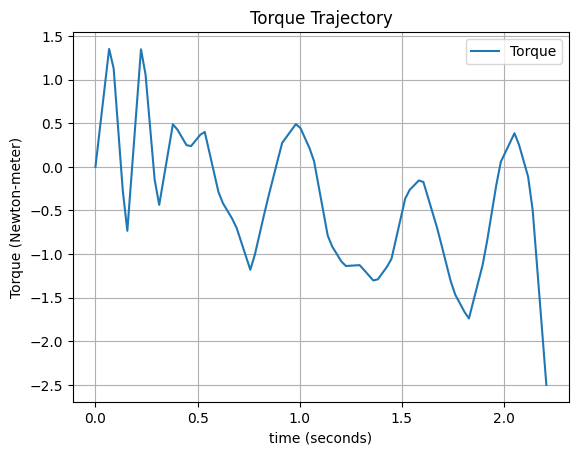

None

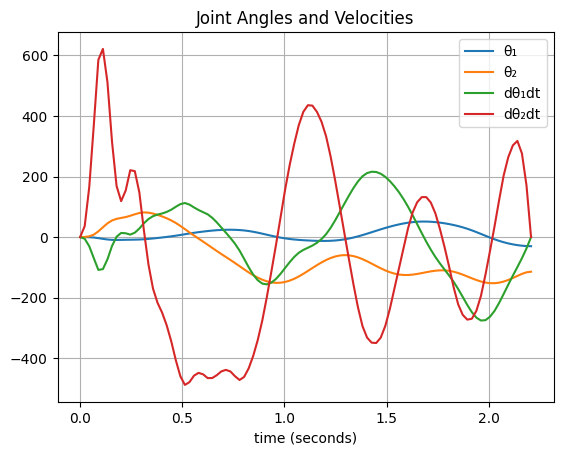

None

Final state of the robot:  [[ 0.00000000e+00 -8.06544132e-04 -7.37608500e-03 -2.59334853e-02
  -6.06741375e-02 -1.01954897e-01 -1.38548139e-01 -1.59894363e-01
  -1.65186348e-01 -1.61811525e-01 -1.55850038e-01 -1.51830414e-01
  -1.47454801e-01 -1.39627246e-01 -1.25446925e-01 -1.04857308e-01
  -7.96813914e-02 -5.16241252e-02 -2.20872010e-02  9.16230524e-03
   4.29020676e-02  8.00726939e-02  1.21200878e-01  1.64293433e-01
   2.07089372e-01  2.46954692e-01  2.83355353e-01  3.16753024e-01
   3.47436885e-01  3.74490335e-01  3.96560978e-01  4.12338833e-01
   4.21428904e-01  4.23678303e-01  4.18772773e-01  4.05717845e-01
   3.82962688e-01  3.49996900e-01  3.06476716e-01  2.54250864e-01
   1.96387734e-01  1.35907691e-01  7.62134858e-02  1.99653358e-02
  -3.08250741e-02 -7.42666836e-02 -1.10040603e-01 -1.38927539e-01
  -1.61762548e-01 -1.80248397e-01 -1.95324643e-01 -2.07423195e-01
  -2.16652818e-01 -2.21734797e-01 -2.21173831e-01 -2.13418424e-01
  -1.96600226e-01 -1.69879902e-01 -1.32647096e-01

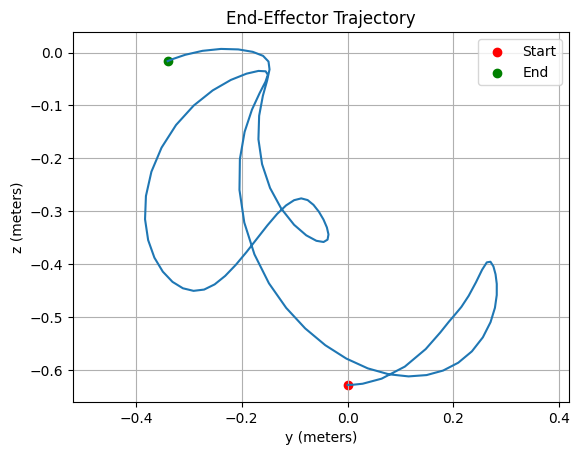

In [9]:
fig, ax = plt.subplots()

times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_values = u_trajectory.vector_values(times)

ax.plot(times, u_values.T)
ax.set_xlabel("time (seconds)")
ax.set_ylabel("Torque (Newton-meter)")
plt.title("Torque Trajectory")
plt.grid()
plt.legend(["Torque"])
display(plt.show())

x_values = x_trajectory.vector_values(times)

plt.figure()
plt.plot(times, np.rad2deg(x_values.T), label=["θ₁", "θ₂", "dθ₁dt", "dθ₂dt"])
plt.xlabel("time (seconds)")
plt.legend()
plt.title("Joint Angles and Velocities")
plt.grid()
display(plt.show())

print("Final state of the robot: ", x_values)

# Plotting end-effector trajectory
ee_y_values = []
ee_z_values = []
for i in range(len(x_values[0])):
    ee_y, ee_z = forward_kinematics(x_values[0][i], x_values[1][i])
    ee_y_values.append(ee_y)
    ee_z_values.append(ee_z)
plt.figure()
plt.plot(ee_y_values, ee_z_values)
plt.xlabel("y (meters)")
plt.ylabel("z (meters)")
plt.title("End-Effector Trajectory")
plt.grid()
plt.axis('equal')
# plot start and end points
plt.scatter(ee_y_values[0], ee_z_values[0], color='red', label='Start')
plt.scatter(ee_y_values[-1], ee_z_values[-1], color='green', label='End')

plt.legend()

plt.show()